In [7]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

## Определить какое количество средств необходимо положить на fixed income часть

In [2]:
zero_coupon = 4.12 / 100 #находим на 2 октября 2020
tenor = 0.5 #срок размещения 6 месяцев
price = 1.00001 / ((1 + zero_coupon) ** tenor)#дисконтируем по найденной ставке
round(price*100)

98

## Определить дисконт облигации - количество средств, которые можно потратить на покупку опциональности

In [3]:
discount = 1 - price
round(discount*100)

2

## Посчитать стоимость опциона из описания доп. дохода в питч ВТБ для 100% номинала:

In [4]:
def count_pitch_vtb(s, k, r, q, sigma, dt):
    d2 = (1 / (sigma * np.sqrt(dt))) * (np.log(s / k) + (r - q - (sigma ** 2) * 0.5) * dt)
    return np.exp (-r * dt) * norm.cdf(- d2)

pitch_vtb = count_pitch_vtb(1, 0.95, zero_coupon, 0.0009, 0.169575, 0.5)
round(pitch_vtb*100)

29

## Определить на какой номинал необходимо купить опцион, чтобы обеспечить заявленную потенциальную доходность:

In [5]:
nominal = round(1.1 ** (0.5) - 1, 2)
nominal

0.05

## Определить итоговую стоимость опциона в % от номинала облигации :

In [6]:
final = round(nominal * pitch_vtb, 3)* 100
round(final, 1)

1.4

## Определить тип payoff

In [7]:
x = np.linspace(80, 120, 121)

def f1(x):
    return np.where(x >= 80, 2, -20)

def f2(x):
    return np.where(x <= 95, 10, np.where((x >= 95) & (x < 95), x, -1.4))

def f3(x):
    return f1(x) + f2(x)

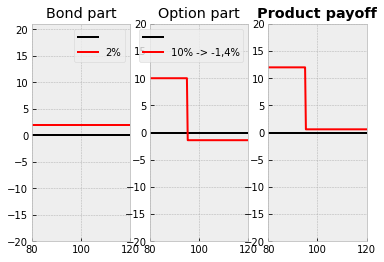

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.rcParams['figure.figsize'] = (20, 5)
ax1.set_xlim(80, 120)
ax1.set_ylim(-20, 21)
ax1.plot(x * 0, c='black')
ax1.plot(x, f1(x), c='red')
ax1.set_title("Bond part")
ax1.legend(['','2%'])

ax2.set_xlim(80, 120)
ax2.set_ylim(-20, 20)
ax2.plot(x * 0, c='black')
ax2.plot(x, f2(x), c='red')
ax2.set_title("Option part")
ax2.legend(['','10% -> -1,4%'])

ax3.set_xlim(80, 120)
ax3.set_ylim(-20, 20)
ax3.plot(x * 0, c='black')
ax3.plot(x, f3(x), c='red')
ax3.set_title("Product payoff", weight="bold")

plt.show()

## Посчитать премию за проданный опцион

In [9]:
zero_coupon_rate = 4.98 / 100

def count_opt_price(S, X, r, sigma, T):
    d1 = (1 / (sigma * np.sqrt(T))) * (np.log(S / X) + (r + (sigma ** 2) * 0.5) * T)
    d2 = (1 / (sigma * np.sqrt(T))) * (np.log(S / X) + (r - (sigma ** 2) * 0.5) * T)
    nd1 = norm.cdf(-d1)
    nd2 = norm.cdf(-d2)
    f = S * np.exp(r * T)
    return round(np.exp(-r * T) * (X * nd2 - f * nd1), 4)

opt_price = count_opt_price(1, 0.7, zero_coupon_rate, 0.3, 3)
opt_price*100

3.46

## Перевести премию из % от номинала в % годовых

In [10]:
annual_inc = round(1.0346 ** (1 / 3) - 1, 4)
round(annual_inc*100, 2)

1.14

## Указать какой получается итоговая доходность по облигации с учетом проданного пута

In [11]:
total = round(((1 + opt_price) * (1 + 0.0498) ** 3) ** (1 / 3) - 1, 4)
total*100

6.18

# 3 неделя

## Запрайсить 3y Barrier Reverse Convertible 

In [1]:
def lambd(r = 0.0498, q = 0, sigma = 0.3):
    return ((r-q+(sigma**2)/2)/(sigma**2))

In [2]:
def y(r = 0.0498, q = 0, sigma = 0.3, T = 3, S_0 = 1, H = 0.7, K = 1):
    return (np.log(H**2/(S_0*K))/(sigma*np.sqrt(T))+lambd(r, q, sigma)*sigma*np.sqrt(T))

In [3]:
def x_1(r = 0.0498, q = 0, sigma = 0.3, T = 3, S_0 = 1, H = 0.7):
    return(np.log(S_0/H)/(sigma*np.sqrt(T))+lambd(r, q, sigma)*sigma*np.sqrt(T))

In [4]:
def y_1(r = 0.0498, q = 0, sigma = 0.3, T = 3, S_0 = 1, H = 0.7):
    return(np.log(H/S_0)/(sigma*np.sqrt(T))+lambd(r, q, sigma)*sigma*np.sqrt(T))

In [5]:
def count_price_di(r = 0.0498, q = 0, sigma = 0.3, T = 3, S_0 = 1, H = 0.7, K = 1):
    nx1 = norm.cdf(-x_1())
    ny1 = norm.cdf(y_1())
    nx1_ = norm.cdf(-x_1() + sigma*np.sqrt(T))
    ny1_ = norm.cdf(y_1() - sigma*np.sqrt(T))
    ny_ = norm.cdf(y() - sigma*np.sqrt(T))
    ny = norm.cdf(y())
    price = -S_0*nx1*np.exp(-q*T) + K*np.exp(-r*T)*nx1_ + S_0*np.exp(-q*T)*(H/S_0)**(2*lambd())*(ny-ny1) - K*np.exp(-r*T)*(H/S_0)**(2*lambd() - 2)*(ny_ - ny1_)
    return price

In [10]:
count_price_di()*100

12.009380201342278

## переводим в % годовых 

In [9]:
annual_inc = round(1.12 ** (1 / 3) - 1, 4)
round(annual_inc*100, 2)

3.85